#### Appendix: arxiv_cs_papers_classification

This is a simple model for classifying the paper category in CS. The data has been gathered from the scraped information on 3000 recent computer science papers from http://arxiv.org

In [1]:
import pandas as pd 
import sklearn
import numpy as np
import nltk
import re
import matplotlib.pyplot as plt
import seaborn as sns
# nltk.download('stopwords') # Ucomment if it hasn't been downloaded yet
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import linear_model
import warnings
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import StratifiedKFold
import gensim
from gensim.models import Word2Vec

We want to build the model based on NLP for title and classify it according to it's label (Category). As you can see in the table below, we have shown a random selection of 10 papers in which each title is associated with its defined category on arxiv. The left nuumbers are the indices for papers that goes all the way from 0 to 2999 for a total of 3000 papers. 

In [24]:
# Reading the data from 3000 scraped papers
df = pd.read_csv('papers.csv')
df.shape
pd.set_option('max_colwidth', 900)
df.sample(10).iloc[:,0:2]

,Title,Category
1991,A Two-stage Deep Network for High Dynamic Range Image Reconstruction,CV
217,Continuous Decoding of Daily-Life Hand Movements from Forearm Muscle Activity for Enhanced Myoelectric Control of Hand Prostheses,RO
231,Algorithmic Factors Influencing Bias in Machine Learning,LG
2249,Consistent Accelerated Inference via Confident Adaptive Transformers,CL
958,Attention on Global-Local Embedding Spaces in Recommender Systems,IR
2442,"3-Coloring on Regular, Planar, and Ordered Hamiltonian Graphs",CC
2543,Data Augmentation for Voice-Assistant NLU using BERT-based Interchangeable Rephrase,CL
2707,Faithful and Plausible Explanations of Medical Code Predictions,LG
2815,Image Super-Resolution via Iterative Refinement,CV
693,Ideology in Open Source Development,SE


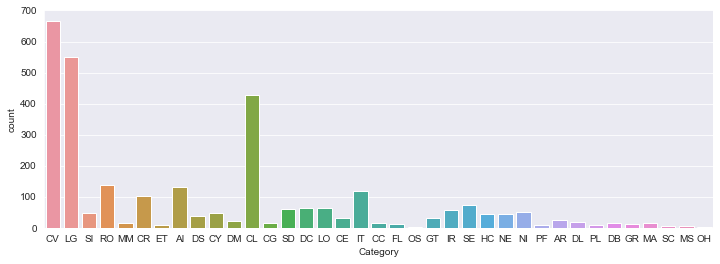

In [18]:
plt.figure(figsize=(12,4))
sns.set_style("darkgrid")
sns.countplot(x="Category",data=df);

Looks like CV (Computer Vision), LG (machine LearninG) and CL (Computation and Language) were the most frequent categories in recent computer science papers

In [8]:
print("Number of unique categories in dataframe:",len(df.Category.unique()))
all_cat = ['AI','CL','CC','CE','CG','GT','CV','CY','CR','DS','DB','DL','DM','DC',
           'ET','FL','GL','GR','AR','HC','IR','IT','LO','LG','MS','MA','MM','NI',
           'NE','NA','OS','OH','PF','PL','RO','SI','SE','SD','SC','SY']
for i in all_cat:
    if i not in df.Category.unique():
        print(i)
titles = df['Title'] 
labels = df['Category']

Number of unique categories in dataframe: 37
GL
NA
SY


looks like General Literature (GL), Numerical Analysis (NA) and Systems and Control (SY) hasn't been in recent papers

In [9]:
# Preprocessing
processed_titles_wordlist = []
processed_titles = []
stops = set(stopwords.words('english'))
for i in range( 0, titles.size):
    words = titles[i].lower().split()
    words = [w.lower() for w in words if not w in stops]  
    processed_titles_wordlist.append(words)
    processed_titles.append(" ".join(words))
print(processed_titles[0:5])
print(processed_titles_wordlist[0:5])

['exemplar-based 3d portrait stylization', 'large-scale study unsupervised spatiotemporal representation learning', 'learned spatial representations few-shot talking-head synthesis', 'discover unknown biased attribute image classifier', 'mongenet: efficient sampler geometric deep learning']
[['exemplar-based', '3d', 'portrait', 'stylization'], ['large-scale', 'study', 'unsupervised', 'spatiotemporal', 'representation', 'learning'], ['learned', 'spatial', 'representations', 'few-shot', 'talking-head', 'synthesis'], ['discover', 'unknown', 'biased', 'attribute', 'image', 'classifier'], ['mongenet:', 'efficient', 'sampler', 'geometric', 'deep', 'learning']]


### Vectorization and building the model
Now that we cleaned our data and removed the stopwords and gathered a processed title and wordlist, it's time to vectorize title by TFIDF (Term Frequency–Inverse Document Frequency)<br>
.

In [12]:
# Vectorizing by TFIDF and building Document Term Matrix (DTM)
vect = TfidfVectorizer()
dtm = vect.fit_transform(processed_titles).toarray()
chisqModel = SelectKBest(chi2,k=5655)
chisqDtm = chisqModel.fit_transform(dtm,labels)

def makeFeatureVec(words, model, num_features):
    feature_vec = np.zeros((num_features,),dtype="float32")
    nwords = 0
    index2word_set = set(model.wv.index2word)
    for word in words:
        if word in index2word_set: 
            nwords += 1
            feature_vec = np.add(feature_vec,model.wv[word]) 

    feature_vec = np.divide(feature_vec,nwords)
   
    return feature_vec

def getAvgFeatureVecs(title, model, num_features):
    counter = 0
    titleFeatureVecs = np.zeros((len(title), num_features),dtype="float32")
    for t in title:
        titleFeatureVecs[counter] = makeFeatureVec(t, model,num_features)
        counter += 1
    return titleFeatureVecs

word2vec_model = Word2Vec(processed_titles_wordlist, workers=1, 
            size=5655, min_count = 1, 
            window = 8, sample = 1e-5)
word2vec_model.init_sims(replace=True)
wordVecs = getAvgFeatureVecs(processed_titles_wordlist, word2vec_model, 5655)
combinedFeatures = np.hstack([chisqDtm,wordVecs])

Finally we feed the data which has been split into train and test set to our model and evaluate our model accuracy.

In [13]:
# Building the model
skf = StratifiedKFold(n_splits=10)
skf.get_n_splits(combinedFeatures, labels)
warnings.filterwarnings("ignore", category=UserWarning)
for train_index, test_index in skf.split(combinedFeatures,labels):
    X_train, X_test = combinedFeatures[train_index], combinedFeatures[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    model = linear_model.RidgeClassifier().fit(X_train, y_train)
    y_pred = model.predict(X_test)
print("Model accuracy:",round(sklearn.metrics.accuracy_score(y_test, y_pred),2))

Model accuracy: 0.57
